# Estimating the counts of seals from citizen scientist tags for the entire Antarct continent
The code below calculates the estimated number of seals counted by citizen scientists, using the methods published in the paper “How many seals do you see? A method for correcting error and increasing reliability of Weddell seal numbers from citizen scientist counts of satellite images”, by L. Salas, M. LaRue, N. Nur, D.G. Ainley, S.E. Stammerjohn, J. Pennycook, J. Rotella, J.T. Paterson, K. Stamatiou, M. Dozier, J. Saints, and L. Barrington (submitted to Methds in Ecology and Evolution). Because some of the tagging campaigns were not very thorough, an enhancement to the calculation is used, and described in [this](https://docs.google.com/document/d/1q8ihZWXapZW8qtxUmmqdYD1gPEMlglG5nez8BBXPG7Q/edit?usp=sharing) document. 

In [11]:
rm(list=ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,733846,39.2,6619081,353.5,8273852,441.9
Vcells,5360053,40.9,53373731,407.3,66717164,509.1


## Preliminary dependencies: libraries and functions

In [12]:
libs<-c("ggplot2","plyr","dplyr","fitdistrplus")
lapply(libs, require, character.only = TRUE)
pathToLocalGit<-"/home/ubuntu/Workspace/ContinentalWESEestimates/"

######################  FUNCTIONS WE'LL NEED
source(paste0(pathToLocalGit,"scripts/countSealsFromTags_functions.R"))

Loading required package: fitdistrplus

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: survival

Loading required package: npsurv

Loading required package: lsei



[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

### Loading and preparing the data to calculate the estimates

In [13]:
## The taggerId of the expert:
mid<-21758509	## This is Michelle LaRue's tagger Id

## load the data
load(paste0(pathToLocalGit,"data/compiledData.RData"))


##############################
#prepare tag data for the count
tags<-unique(tags)
tgvutm<-merge(tags,views[,c("mapViewId","mapId","region")],by=c("mapViewId","region"),all.x=T)
tgvutm$numTags<-1
tgvutm$regionMapId<-paste0(tgvutm$region,tgvutm$mapId)

#prepare the feature data - for original approach
crt<-merge(crowd[,c("tagId","score","agremnt","sensor","region")],tgvutm[,c("tagId","mapViewId","easting","northing","region","regionTagId","regionMapViewId","regionTaggerId")],by=c("tagId","region"),all.x=T)
crt<-subset(crt,!is.na(mapViewId))
crtm<-merge(crt,views[,c("mapViewId","mapId","region")],by=c("mapViewId","region"),all.x=T)
crtm<-subset(crtm,!is.na(mapId))
crtm$numFeatures<-1
crtm$regionMapId<-paste0(crtm$region,crtm$mapId)

#prepare the tagger crowdrank data
rankdata<-taggers[,c("taggerId","taggerScore","region","regionTaggerId")]

#prepare the expert data
mlCounts<-aggregate(numTags~mapId+region+regionMapId,data=subset(tgvutm,taggerId==mid),FUN=sum)
names(mlCounts)<-c("mapId","region","regionMapId","mlcount")
mlMaps<-unique(subset(views,taggerId==mid))
mlMaps$regionMapId<-paste0(mlMaps$region,mlMaps$mapId)
tagsML<-subset(tgvutm,taggerId==mid)

#Subset the data to only those taggers that overlapped with the expert - find vews, maps, etc.
taggersSel<-unique(subset(views,regionMapId %in% mlMaps$regionMapId,select=c("taggerId","region","regionMapId","regionMapViewId","regionTaggerId")))
taggersSel<-subset(taggersSel,taggerId!=mid)		#taggers who share maps with ML
tagsSel<-subset(tgvutm,regionTaggerId %in% taggersSel$regionTaggerId) 
viewsSel<-subset(views,regionTaggerId %in% c(unique(taggersSel$regionTaggerId),mid))  

##Adding more stringent tagger quality filters
subtaggers<-subset(taggers,taggerScore>0.5 & numApprovedTags > 0)
subtaggers<-subset(subtaggers,regionTaggerId %in% taggersSel$regionTaggerId)   

## Estimate (aporx.) the probability of a feature being found on a map and the probability of a tag being placed on a map
totalMapsInspected<-NROW(unique(views$regionMapId))
totalMapsWtags<-NROW(unique(tgvutm$regionMapId))
totalMapsWfeat<-NROW(unique(crtm$regionMapId))
probFeatInMap<-totalMapsWfeat/totalMapsInspected
probTagInMap<-totalMapsWtags/totalMapsInspected
probTagAsFeat<-totalMapsWfeat/totalMapsWtags


############ Approximating ProbF and ProbS
## ProbF as the probability of placing a tag on a map: num maps with tags/ total num maps inspected
estProbF<-NROW(unique(tgvutm$regionMapId))/NROW(unique(maps$regionMapId))
## ProbS as the probability of ML finding a seal on a map
estProbS<-NROW(unique(tagsML$regionMapId))/NROW(unique(mlMaps$regionMapId))

(estCorr<-estProbS/estProbF)


[1] 0.7581662

Checking that the data do not have duplicate views:

In [14]:
NROW(unique(tgvutm$regionMapViewId))==NROW(unique(tgvutm[,c("regionTaggerId","regionMapId")]))

[1] TRUE

### Shrinking the estimates
In our original approach we assume a universal ProbS (see link to document above), and a tagger ProbT that is invariant for the tagger regardless of the map inspected. In this original approach, ProbF is the prob that any tag is found on a map. So, we define it as: ProbF (for each tagger separately) = number of  tags in maps inspected/total number of maps inspected. We know these two assumptions may not hold.

Here we estimate both the original correction factor (option 1) and the new Q correction coefficient (option 2). For these two approaches, we explore using estimates from each tagger that are region-specific (option 1A or 2A), or general for each tagger regardless of region (options 1B and 2B) 


In [15]:
## Version 1A: region-specific corrFactor estimates for each tagger
gspm<-getTaggerProbabilities_tagsOnlybyTag(rankdata=rankdata,crthr=0.5,taggersSel=subtaggers,tagsSel=tagsSel,tagsML=tagsML,viewsSel=viewsSel,ProbS=estProbS)

## Version 1B: single corrFactor estimate for each tagger
gspmG<-getTaggerProbabilities_tagsOnlybyTag_general(rankdata=rankdata,crthr=0.5,taggersSel=subtaggers,tagsSel=tagsSel,tagsML=tagsML,viewsSel=viewsSel,ProbS=estProbS)

## Option 2 - use Q: the correction coefficient (see link to document above)
## Version 2A: region-specific Qval estimates for each tagger
gspmQ<-getTaggerProbabilities_fromQ(rankdata=rankdata,crthr=0.5,taggersSel=subtaggers,tagsSel=tagsSel,tagsML=tagsML,mapsML=mlMaps,viewsSel=viewsSel)

## Version 2B: single Qval estimate for each tagger
gspmQG<-getTaggerProbabilities_fromQ_general(rankdata=rankdata,crthr=0.5,taggersSel=subtaggers,tagsSel=tagsSel,tagsML=tagsML,mapsML=mlMaps,viewsSel=viewsSel)

############################################################################
## Review the fits and estimates for the correction factors
## Option 1:
print("Option 1A: correction factor from region-specific estimates")
summary(gspm$corrFactor); print(paste("N:",nrow(gspm)))
print("")
print("Option 1B: correction factor from general estimates")
summary(gspmG$corrFactor); print(paste("N:",nrow(gspmG)))
print("")
############################################################################
## Review the fits and estimates for Qvals
## Option 2:
print("Option 2A: Q correction coefficients from region-specific estimates")
summary(gspmQ$Qval); print(paste("N:",nrow(gspmQ)))
print("")
print("Option 2B: Q correction coefficients from region-specific estimates")
summary(gspmQG$Qval); print(paste("N:",nrow(gspmQG)))


[1] "Option 1A: correction factor from region-specific estimates"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.008668 0.163379 0.355401 0.622535 0.812035 4.852705 

[1] "N: 123"
[1] ""
[1] "Option 1B: correction factor from general estimates"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.008668 0.168302 0.362197 0.626719 0.823470 4.852705 

[1] "N: 90"
[1] ""
[1] "Option 2A: Q correction coefficients from region-specific estimates"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01409 0.26584 0.49937 0.61662 0.83393 5.33333 

[1] "N: 130"
[1] ""
[1] "Option 2B: Q correction coefficients from region-specific estimates"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01133 0.26471 0.50909 0.63714 0.90000 2.71875 

[1] "N: 97"


### Review of results - fit probability density functions to the distribution of values
Here we review the results in more detail and fit PDFs to the data. We then decide on the most appropriate estimates to use, and the best PDF to use. 

#### Option 1: The correction factors
Though the region-specific and general estimates of the correction factor are equally dispersed, it is safe to assume that we should use the region-specific values because these are more numerous.

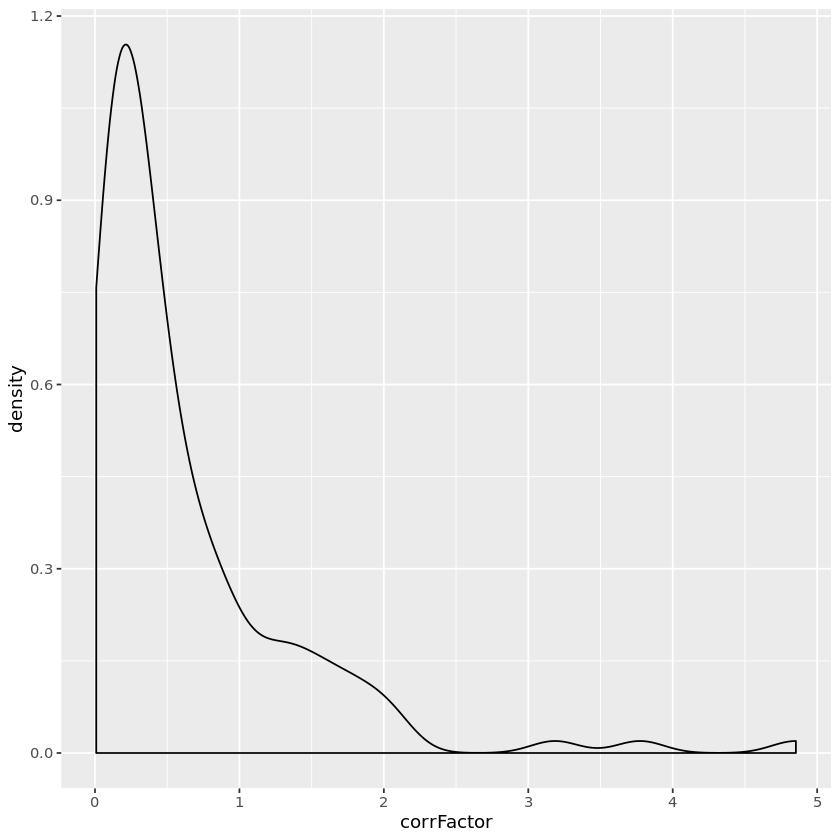

In [16]:
## Checking the distribution of these values
ggplot(gspm,aes(x=corrFactor)) + geom_density()

The above plot shows that it is safe to remove factors of value > 3. There are only 3 of these. 

[1] "Log-normal distribution fit:"


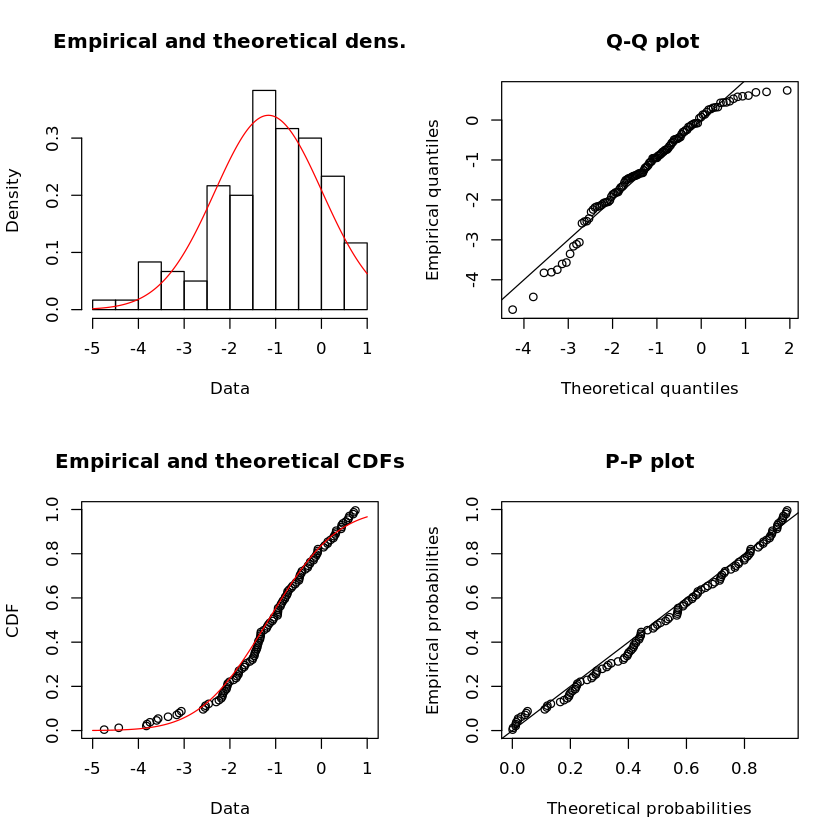

In [17]:
## Here removing the top 3 values
gspm<-subset(gspm,corrFactor < 3)

## Review the distribution fit options: log-normal, gamma or Weibull
print("Log-normal distribution fit:")
tstdist<-fitdist(log(gspm$corrFactor),"norm"); plot(tstdist)	#is log-normal best fit??

[1] "Gamma distribution fit:"


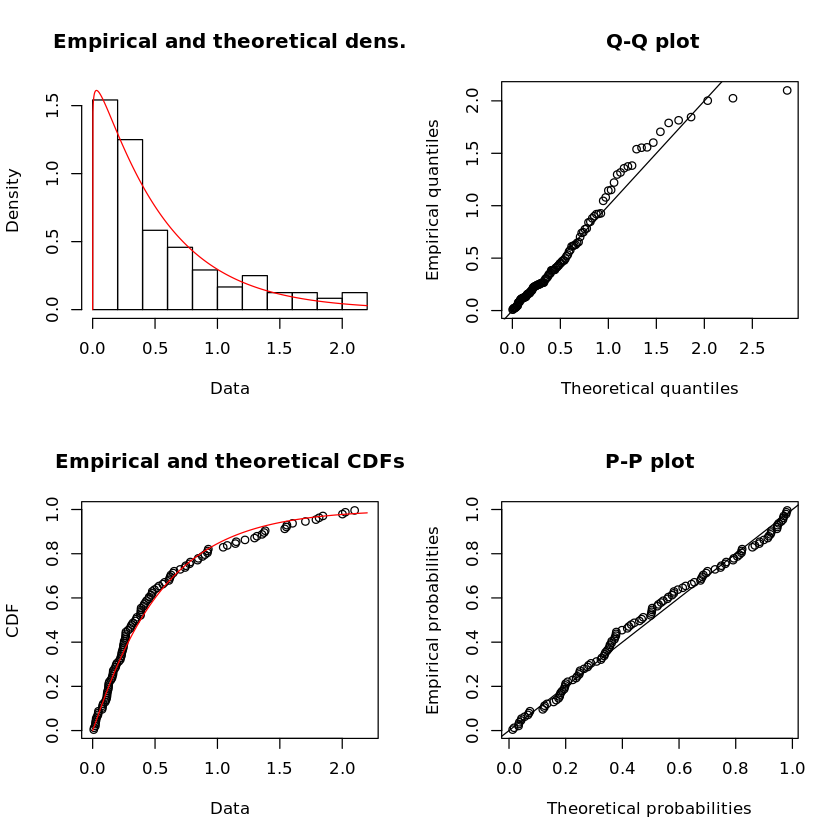

In [18]:
print("Gamma distribution fit:")
tstdist<-fitdist(gspm$corrFactor,"gamma"); plot(tstdist)	#I think gamma/weibull is best

[1] "Weibull distribution fit:"


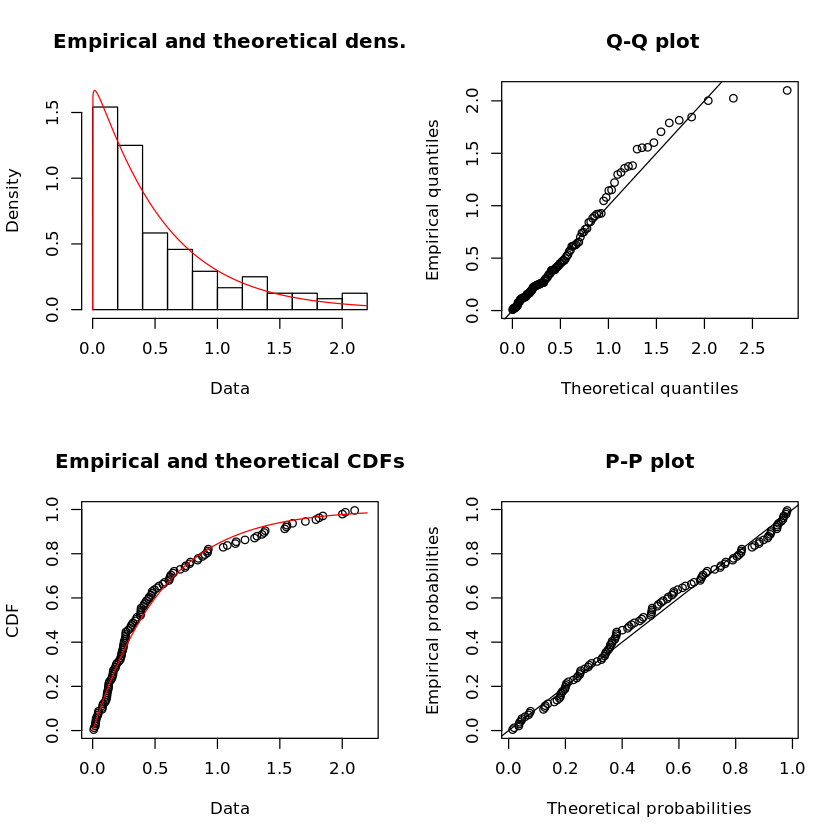

In [19]:
print("Weibull distribution fit:")
tstdist<-fitdist(gspm$corrFactor,"weibull"); plot(tstdist)

Below we compare the mean and limits of the correction factors for the Gamma and Log-normal distributions. 

In [20]:
## Checking to compare 95% confidence limits
cfdist<-fitdist(log(gspm$corrFactor),"norm")$estimate
# lower 95% - mean - upper 95%
print("Log-normal: lower95 - mean - upper95")
paste(round(exp(cfdist[1] - (1.96*cfdist[2])),3),"-",round(exp(cfdist[1]),3),"-",round(exp(cfdist[1] + (1.96*cfdist[2])),3))
# versus
print("Gamma: lower95 - mean - upper95")
cfdist<-fitdist(gspm$corrFactor,"gamma")$estimate
paste(round(qgamma(0.025,cfdist[1],cfdist[2]),3),"-",round(cfdist[1]/cfdist[2],3),"-",round(qgamma(0.975,cfdist[1],cfdist[2]),3))


[1] "Log-normal: lower95 - mean - upper95"


[1] "0.031 - 0.314 - 3.138"

[1] "Gamma: lower95 - mean - upper95"


[1] "0.016 - 0.54 - 1.941"

#### Option 2: the Q coefficients
As with the correction factors above, the the region-specific Q coefficient values are more numerous, but let's inspect the general values too.

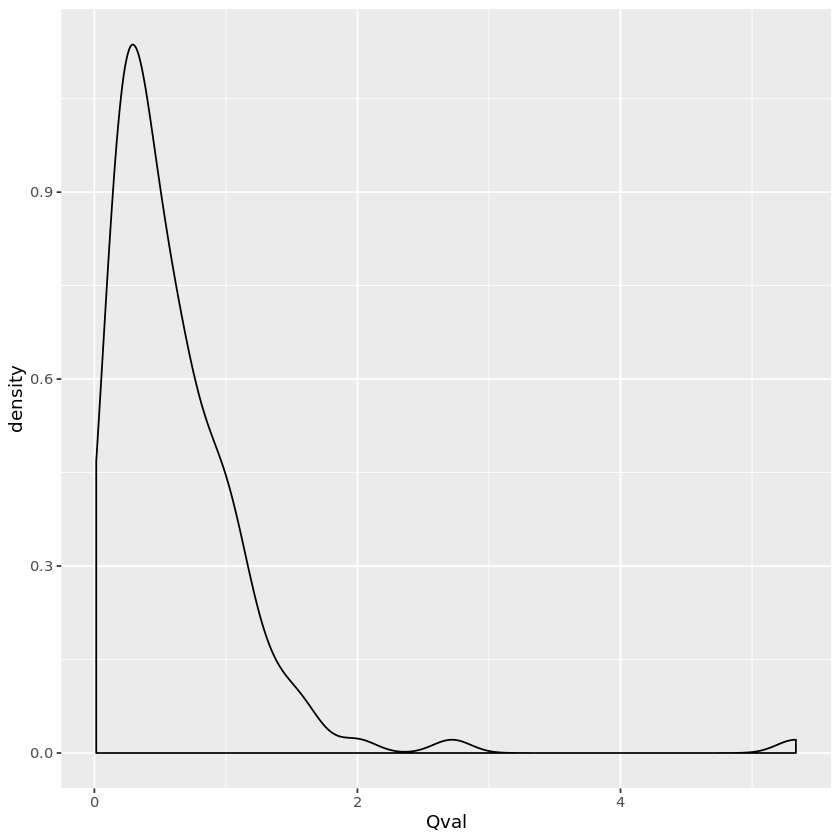

In [21]:
## Checking the distribution of the region-specific tagger values
ggplot(gspmQ,aes(x=Qval)) + geom_density()


We filter for Qval values > 2 (2 records only).
Let's review the distribution fitting options for the region-specific Qval data:

In [22]:
gspmQ<-subset(gspmQ,Qval<=2)

[1] "Log-normal distribution fit:"


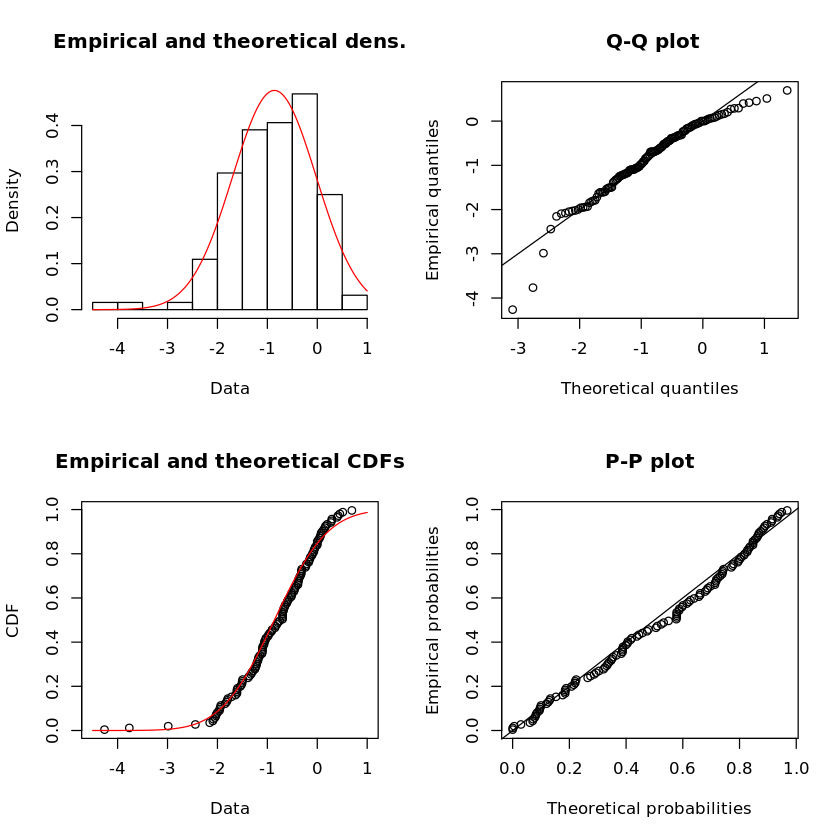

In [23]:
print("Log-normal distribution fit:")
tstdist<-fitdist(log(gspmQ$Qval),"norm"); plot(tstdist)

[1] "Gamma distribution fit:"


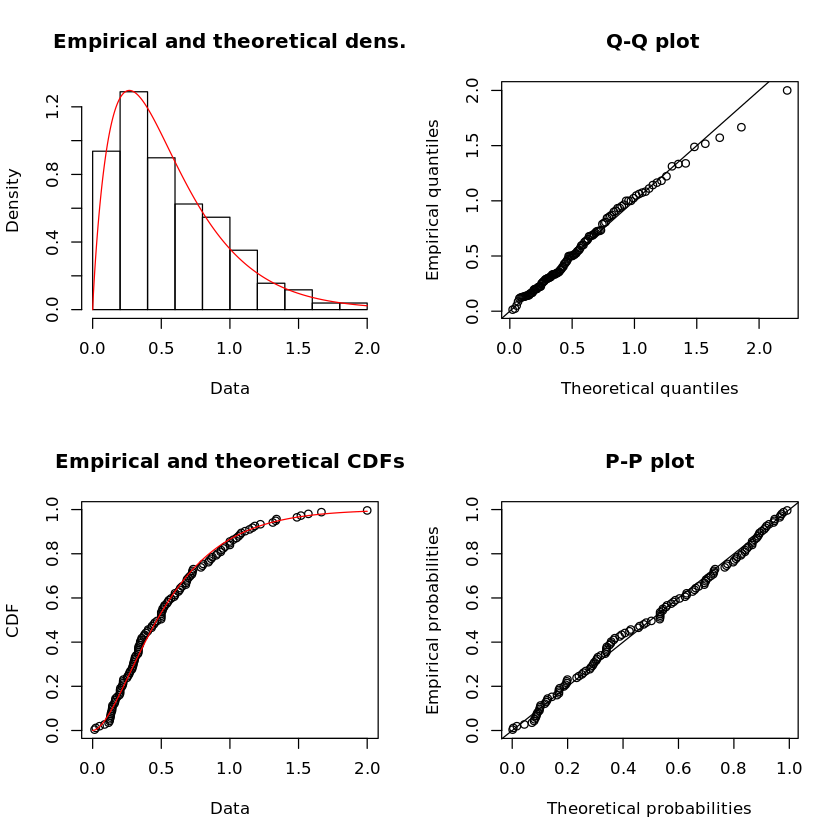

In [24]:
print("Gamma distribution fit:")
tstdist<-fitdist(gspmQ$Qval,"gamma"); plot(tstdist)

[1] "Weibull distribution fit:"


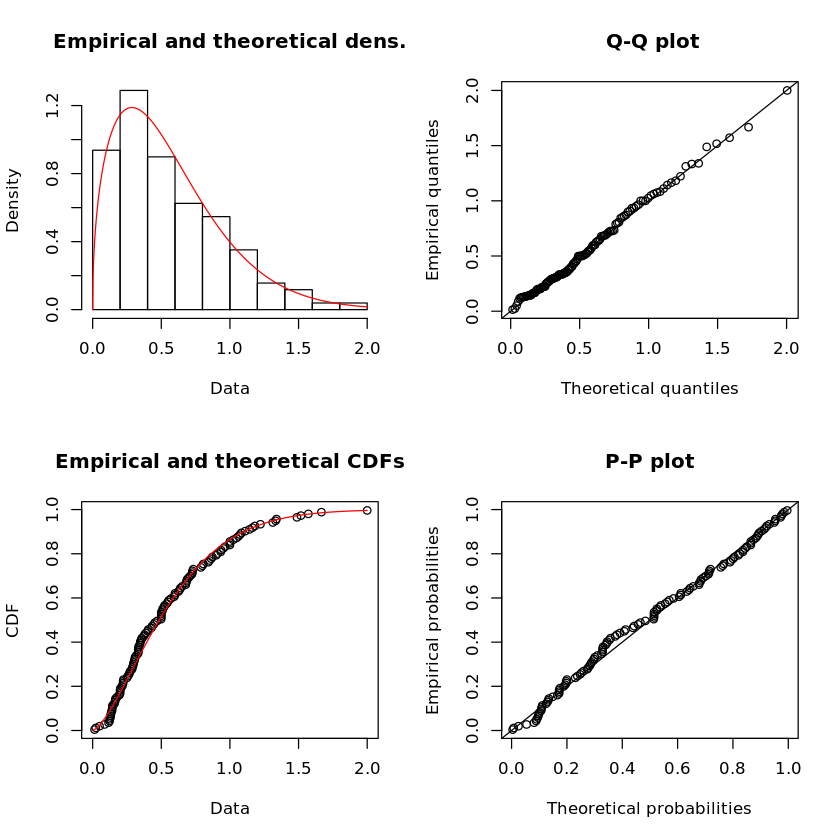

In [25]:
print("Weibull distribution fit:")
tstdist<-fitdist(gspmQ$Qval,"weibull"); plot(tstdist)

Weibull is certainly the best fit. So:

In [26]:
qdist<-fitdist(gspmQ$Qval,"weibull")$estimate
weimean<-qdist[2]*gamma(1+1/qdist[1])
print("Weibull: lower95 - mean - upper95")
paste(round(qweibull(0.025,qdist[1],qdist[2]),3),"-",round(weimean,3),"-",round(qweibull(0.975,qdist[1],qdist[2]),3))

[1] "Weibull: lower95 - mean - upper95"


[1] "0.051 - 0.565 - 1.518"

Let's now check the general Q coefficient estimates:

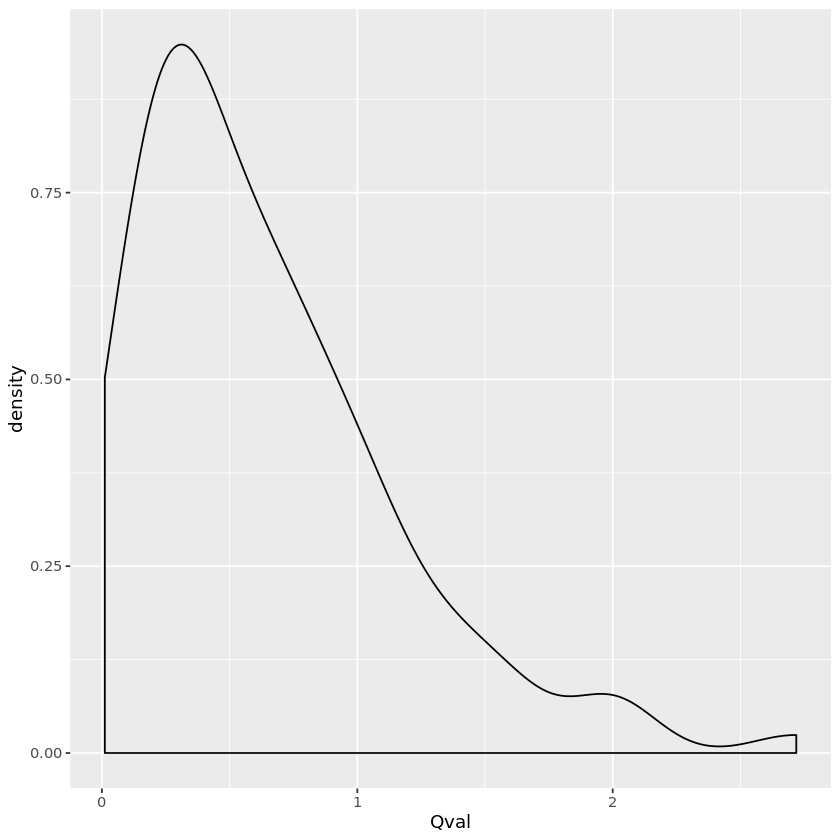

In [27]:
## Checking the distribution of the general tagger values
ggplot(gspmQG,aes(x=Qval)) + geom_density()

We remove the single value >2.5 and review the distribution fitting options for the general Qval data:

In [28]:
gspmQG<-subset(gspmQG, Qval<2.5)

[1] "Log-normal distribution fit:"


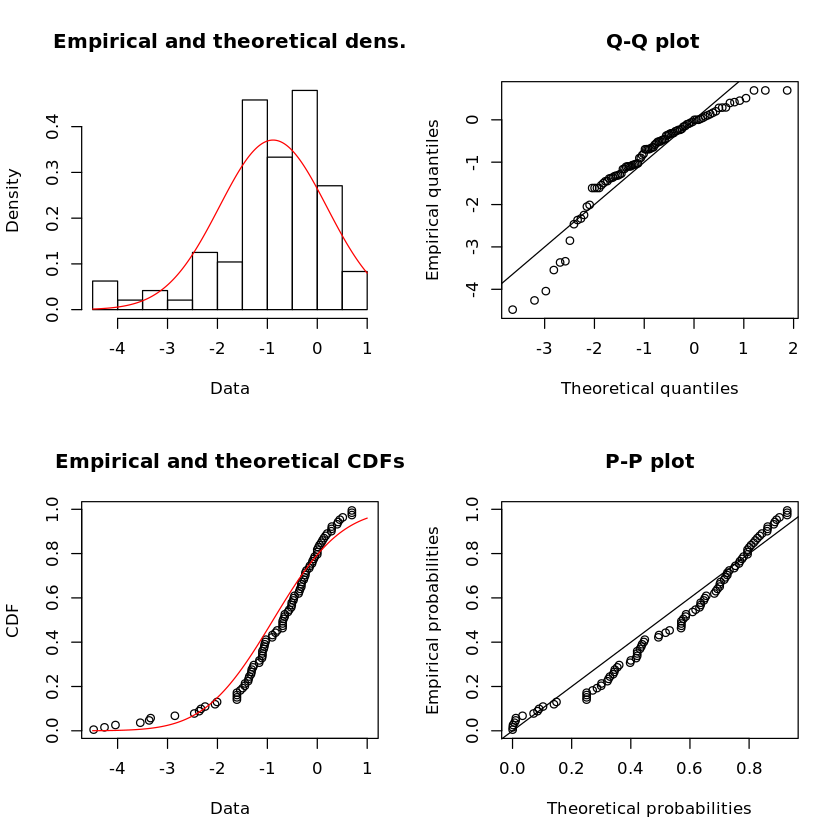

In [29]:
print("Log-normal distribution fit:")
tstdist<-fitdist(log(gspmQG$Qval),"norm"); plot(tstdist)

[1] "Gamma distribution fit:"


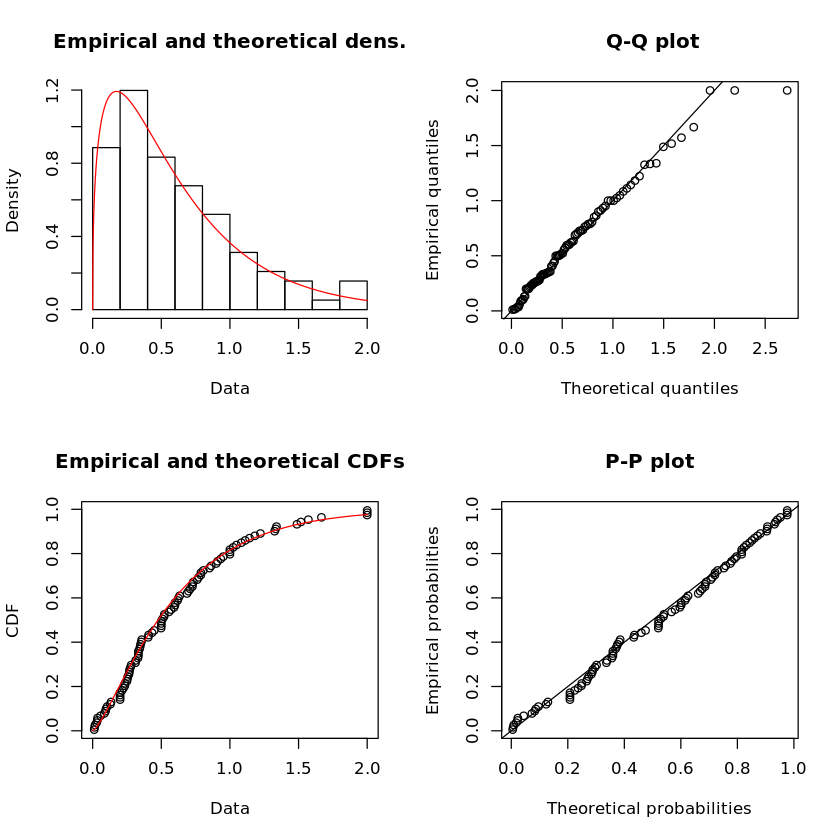

In [30]:
print("Gamma distribution fit:")
tstdist<-fitdist(gspmQG$Qval,"gamma"); plot(tstdist)

[1] "Weibull distribution fit:"


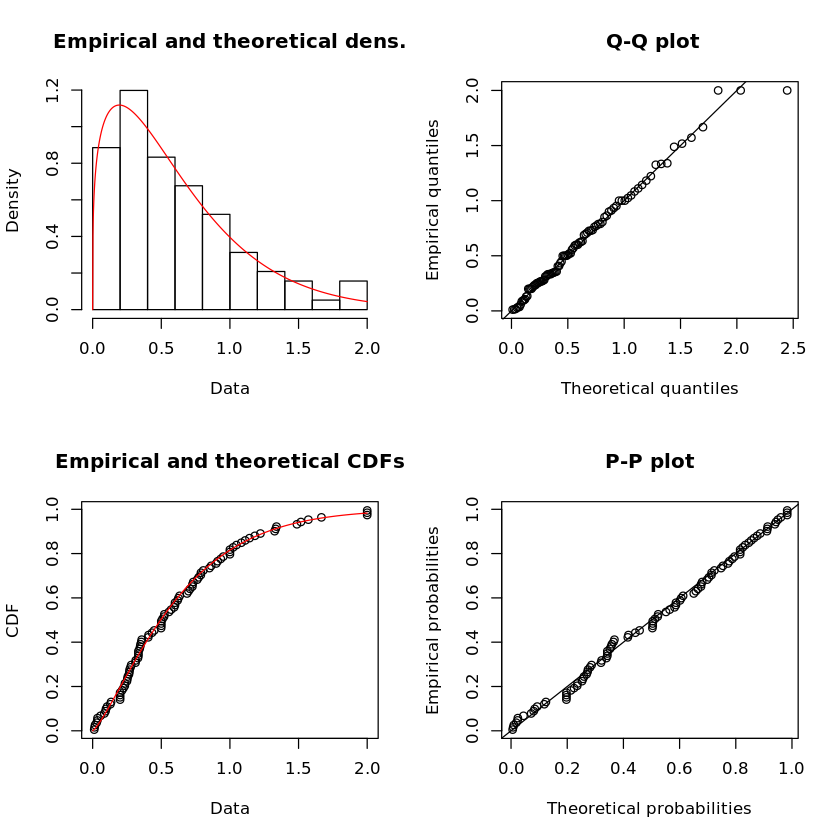

In [31]:
print("Weibull distribution fit:")
tstdist<-fitdist(gspmQG$Qval,"weibull"); plot(tstdist)

Again Weibull is the better fit. Then let's see the distribution values:

In [32]:
qdist<-fitdist(gspmQG$Qval,"weibull")$estimate
weimean<-qdist[2]*gamma(1+1/qdist[1])
print("Weibull: lower95 - mean - upper95")
paste(round(qweibull(0.025,qdist[1],qdist[2]),3),"-",round(weimean,3),"-",round(qweibull(0.975,qdist[1],qdist[2]),3))

[1] "Weibull: lower95 - mean - upper95"


[1] "0.036 - 0.614 - 1.85"

The region-specific estimates are less numerous and more conservative than the general estimates.

## Calculating the number of seals from the tags
Let's calculate seal numbers using the region-specific form:

In [33]:
cival=90
countByQ<-getMapEstimates(cdf=gspmQ,crthr=0.5,taggers=subtaggers,nSealsFilt=8,tgvutm=tgvutm,maps=maps,overlays=overlays,corrMethod="taggerQval",dist="weibull",cival=cival)
estByRegionQ<-as.data.frame(countByQ %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)),estNumSeals=ceiling(sum(estNumSeals)),uclNumSeals=ceiling(sum(uclNumSeals))))
estByRegionQ<-rbind(estByRegionQ,data.frame(region="Total",lclNumSeals=round(sum(countByQ$lclNumSeals)),estNumSeals=round(sum(countByQ$estNumSeals)),uclNumSeals=round(sum(countByQ$uclNumSeals))))
print(estByRegionQ)

  region lclNumSeals estNumSeals uclNumSeals
1    AMU         991        1784        4642
2    EA1        2264        4673       11895
3    EA2        2119        3978       10241
4    QMA        2727        5582       14188
5    RSS        7911       17365       43713
6    WAP        2937        6290       15843
7  Total       18949       39672      100522


If we were to use the general form:

In [34]:
cival=90
countByQG<-getMapEstimates(cdf=gspmQG,crthr=0.5,taggers=subtaggers,nSealsFilt=8,tgvutm=tgvutm,maps=maps,overlays=overlays,corrMethod="taggerQval",dist="weibull",cival=cival)
estByRegionQG<-as.data.frame(countByQG %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)),estNumSeals=ceiling(sum(estNumSeals)),uclNumSeals=ceiling(sum(uclNumSeals))))
estByRegionQG<-rbind(estByRegionQG,data.frame(region="Total",lclNumSeals=round(sum(countByQG$lclNumSeals)),estNumSeals=round(sum(countByQG$estNumSeals)),uclNumSeals=round(sum(countByQG$uclNumSeals))))
print(estByRegionQG)


  region lclNumSeals estNumSeals uclNumSeals
1    AMU        1010        1944        5023
2    EA1        2335        5198       13119
3    EA2        2161        4433       11306
4    QMA        2802        6209       15713
5    RSS        8142       19377       48615
6    WAP        3021        7012       17607
7  Total       19471       44173      111383


For comparison, let's see the estimates using the original correction factors:

In [35]:
cival=90
countBySS<-getMapEstimates(cdf=gspm,crthr=0.5,taggers=subtaggers,tgvutm=tgvutm,maps=maps,overlays=overlays,corrMethod="taggerCorrFactor",dist="gamma",cival=cival)
estByRegionSS<-as.data.frame(countBySS %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)),estNumSeals=ceiling(sum(estNumSeals)),uclNumSeals=ceiling(sum(uclNumSeals))))
estByRegionSS<-rbind(estByRegionSS,data.frame(region="Total",lclNumSeals=round(sum(countBySS$lclNumSeals)),estNumSeals=round(sum(countBySS$estNumSeals)),uclNumSeals=round(sum(countBySS$uclNumSeals))))
print(estByRegionSS)


  region lclNumSeals estNumSeals uclNumSeals
1    AMU         958        1727        5159
2    EA1        2112        4493       13420
3    EA2        2042        3880       11545
4    QMA        2559        5405       16123
5    RSS        7200       16673       49765
6    WAP        2722        6065       18007
7  Total       17593       38243      114019


Unfortunately, the numbers using the original correction factor are probably incorrect. As evident in the graph below comparing estimates to the expert count, the values are lower than they should. So, we cannot work with the estimates from the original correction factor because the sample of surveyors is too biased!
* The blue line is the 1:1 relationship, our expectation if the values are correct
* The red line is the resulting relationship. Note the substatial under-estimation

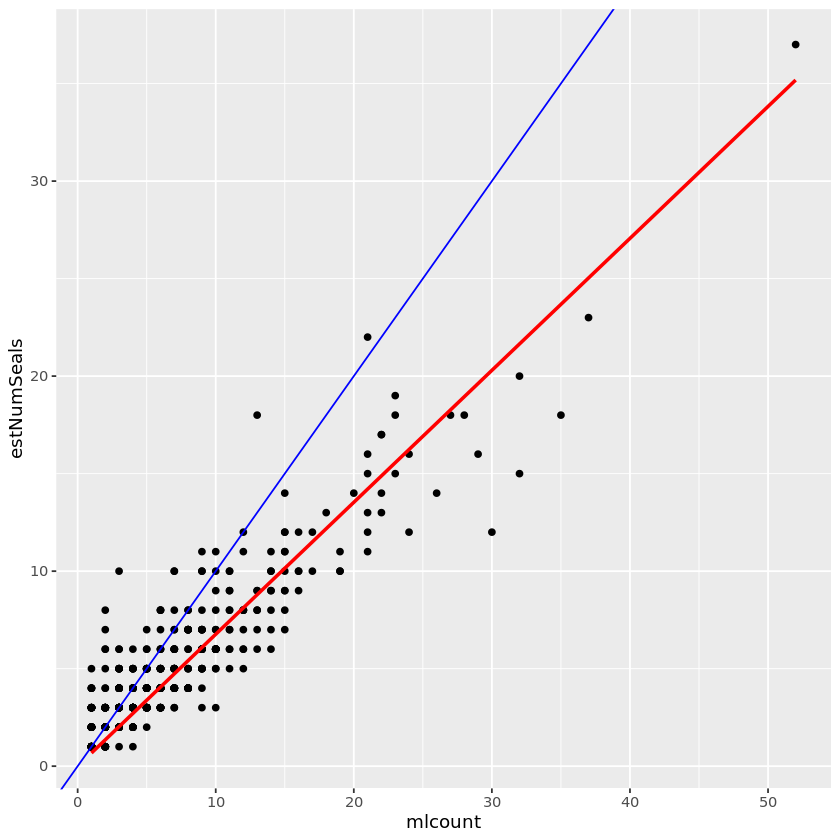

In [36]:
countBySS<-merge(countBySS,mlCounts[,c("regionMapId","mlcount")],by="regionMapId",all.x=T)
ggplot(subset(countBySS,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")

We can do the same evaluation for the Q coefficients from the region-specific estimates, and see that these seem to underestimate a little the true number of seals in images

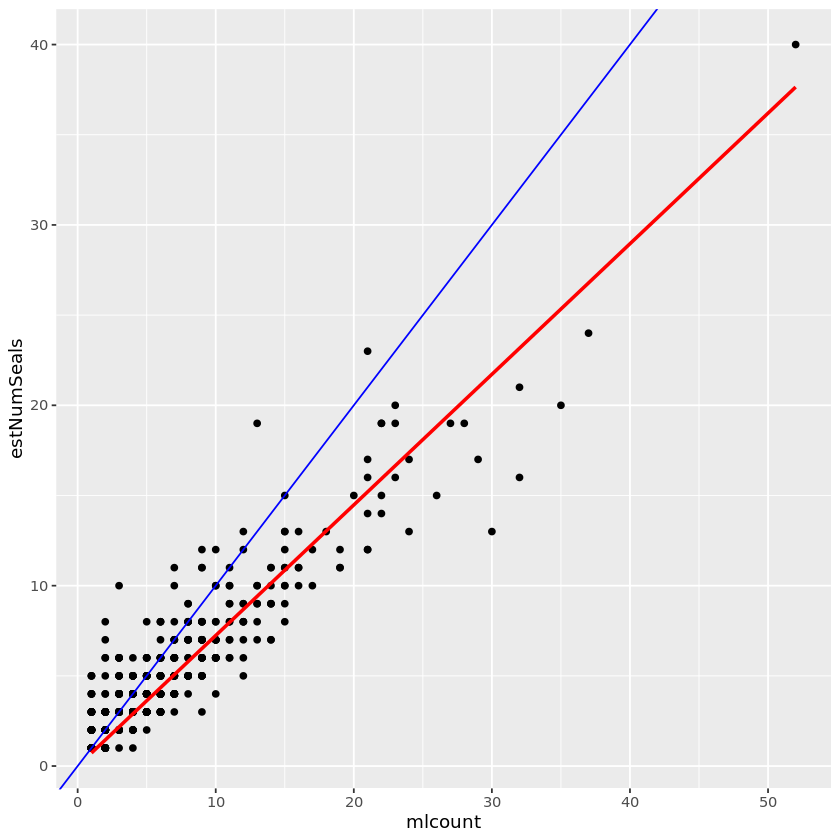

In [37]:
countByQ<-merge(countByQ,mlCounts[,c("regionMapId","mlcount")],by="regionMapId",all.x=T)
ggplot(subset(countByQ,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")


Using the general estimates for the Q coefficients works better when compared to the expert. This is expected, as this method produced the highest count estimates.

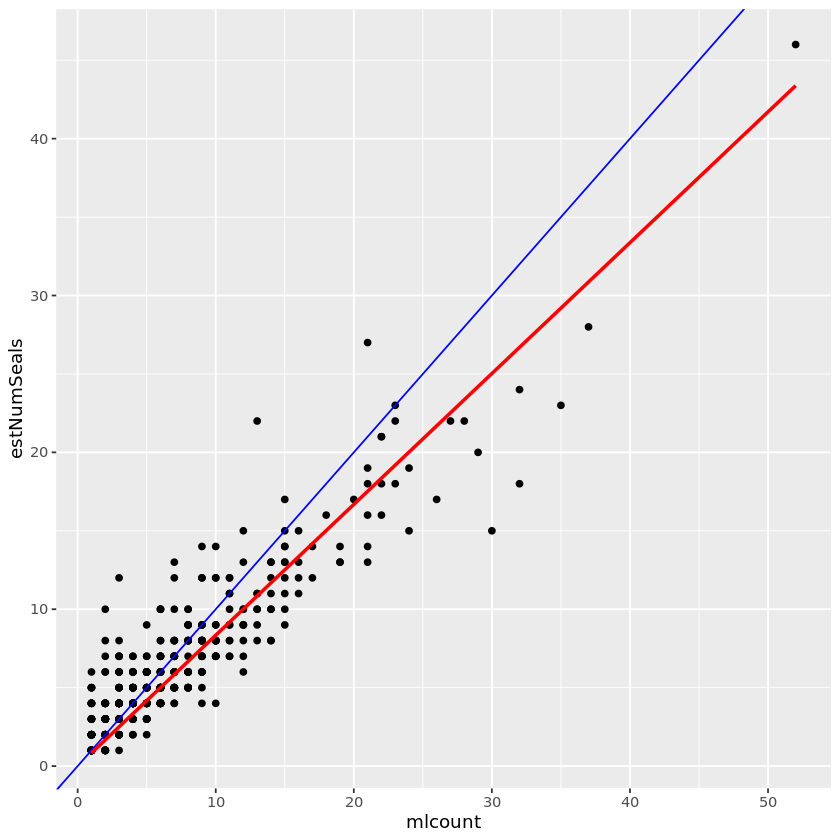

In [38]:
countByQG<-merge(countByQG,mlCounts[,c("regionMapId","mlcount")],by="regionMapId",all.x=T)
ggplot(subset(countByQG,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")


## Reviewing results

The above results indicate that the distribution of Qvalues and correction factors from the sample of taggers from which these could be estimated results in an underestimate of the true presence of seals in maps (as measured by the expert's counts). Thus, we could use any of the above three correction methods and still need to inflate results a little bit.

  region lclNumSeals estNumSeals uclNumSeals
1    AMU        1368        2462        6406
2    EA1        3125        6449       16416
3    EA2        2925        5490       14133
4    QMA        3764        7704       19580
5    RSS       10918       23964       60324
6    WAP        4054        8681       21864
7  Total       26150       54747      138720


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.380   1.380   1.380   3.138   2.760  77.280 

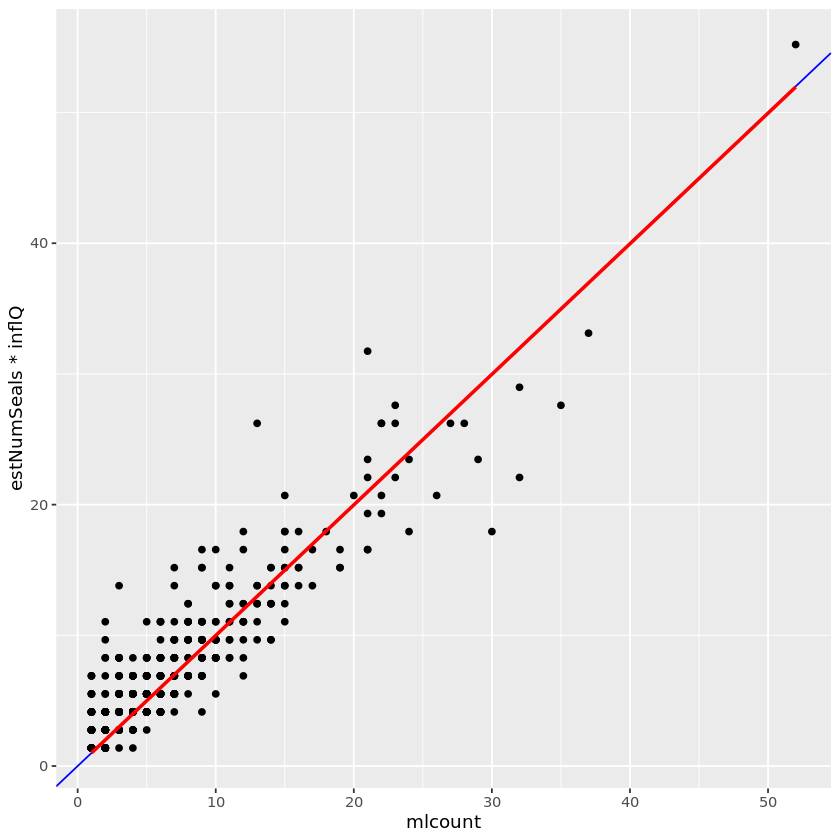

In [39]:
inflQ<-1.38    #inflating...
estByRegionQ<-as.data.frame(countByQ %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)*inflQ),estNumSeals=ceiling(sum(estNumSeals)*inflQ),uclNumSeals=ceiling(sum(uclNumSeals)*inflQ)))
estByRegionQ<-rbind(estByRegionQ,data.frame(region="Total",lclNumSeals=round(sum(countByQ$lclNumSeals)*inflQ),estNumSeals=round(sum(countByQ$estNumSeals)*inflQ),uclNumSeals=round(sum(countByQ$uclNumSeals)*inflQ)))
print(estByRegionQ)
ggplot(subset(countByQ,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals*inflQ)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")
summary(countByQ$estNumSeals*inflQ)

For the continent-wide Qvalues (underestimates by 20%):

  region lclNumSeals estNumSeals uclNumSeals
1    AMU        1212        2333        6028
2    EA1        2802        6238       15743
3    EA2        2594        5320       13568
4    QMA        3363        7451       18856
5    RSS        9771       23253       58338
6    WAP        3626        8415       21129
7  Total       23365       53008      133660


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.200   1.200   1.200   3.038   3.600  78.000 

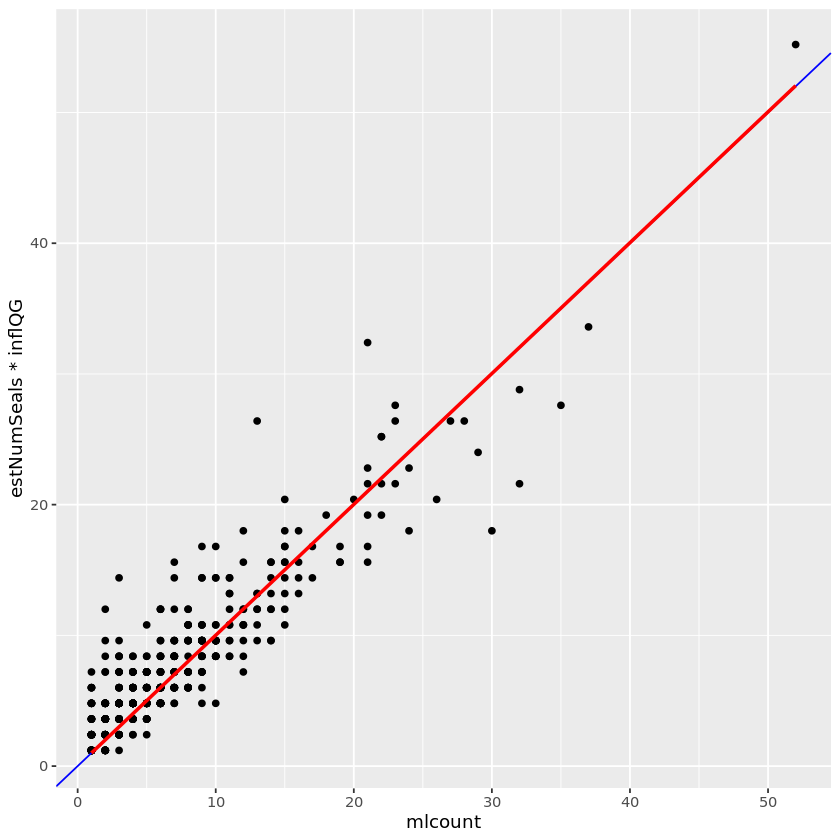

In [40]:
inflQG<-1.2
estByRegionQG<-as.data.frame(countByQG %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)*inflQG),estNumSeals=ceiling(sum(estNumSeals)*inflQG),uclNumSeals=ceiling(sum(uclNumSeals)*inflQG)))
estByRegionQG<-rbind(estByRegionQG,data.frame(region="Total",lclNumSeals=round(sum(countByQG$lclNumSeals)*inflQG),estNumSeals=round(sum(countByQG$estNumSeals)*inflQG),uclNumSeals=round(sum(countByQG$uclNumSeals)*inflQG)))
print(estByRegionQG)
ggplot(subset(countByQG,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals*inflQG)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")
summary(countByQG$estNumSeals*inflQG)

And if using the more general SS correction factor (underestimates by 48%):

  region lclNumSeals estNumSeals uclNumSeals
1    AMU        1418        2556        7636
2    EA1        3126        6650       19862
3    EA2        3023        5743       17087
4    QMA        3788        8000       23863
5    RSS       10656       24677       73653
6    WAP        4029        8977       26651
7  Total       26038       56600      168748


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.480   1.480   1.480   3.244   2.960  76.960 

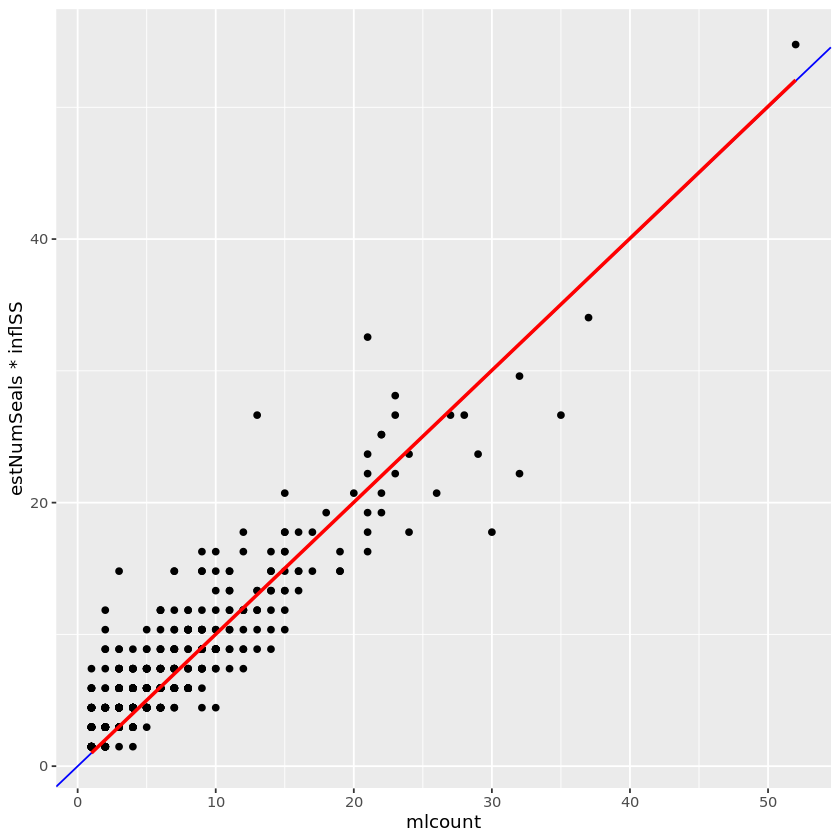

In [41]:
inflSS<-1.48
estByRegionSS<-as.data.frame(countBySS %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)*inflSS),estNumSeals=ceiling(sum(estNumSeals)*inflSS),uclNumSeals=ceiling(sum(uclNumSeals)*inflSS)))
estByRegionSS<-rbind(estByRegionSS,data.frame(region="Total",lclNumSeals=round(sum(countBySS$lclNumSeals)*inflSS),estNumSeals=round(sum(countBySS$estNumSeals)*inflSS),uclNumSeals=round(sum(countBySS$uclNumSeals)*inflSS)))
print(estByRegionSS)
ggplot(subset(countBySS,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals*inflSS)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")
summary(countBySS$estNumSeals*inflSS)


Our correction using the general Q factor (countByQG) is the top choice:
* It requires the least inflation (20%) 
* It has the narrowest confidence interval  
  
Incidentally, it also results in the lower estimates

In [42]:
counts<-countByQG
counts$estNumSeals<-round(counts$estNumSeals*inflQG)
counts$uclNumSeals<-round(counts$uclNumSeals*inflQG)
counts$lclNumSeals<-round(counts$lclNumSeals*inflQG)
summary(counts$estNumSeals)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    1.00    2.91    4.00   78.00 

## Reviewing the counts by sensor type
It is unlikely that there will be > 100 seals in a map. In fact, more than 40 seals is rare. Fotunately, no map has an estimate >100 seals (the higher number is 78), and very few have more than 40 seals. We recall that in Erebus Bay high estimated counts were associated with sensor QB02. Here we examine how the counts distribute by sensor type.

First, we must add hour and sensor type information to our data, then we examine if the extreme estimates are associated with a particular sensor. 

satId,regionMapId
<chr>,<int>
GE01,9
QB02,3383
WV01,7846
WV02,6211


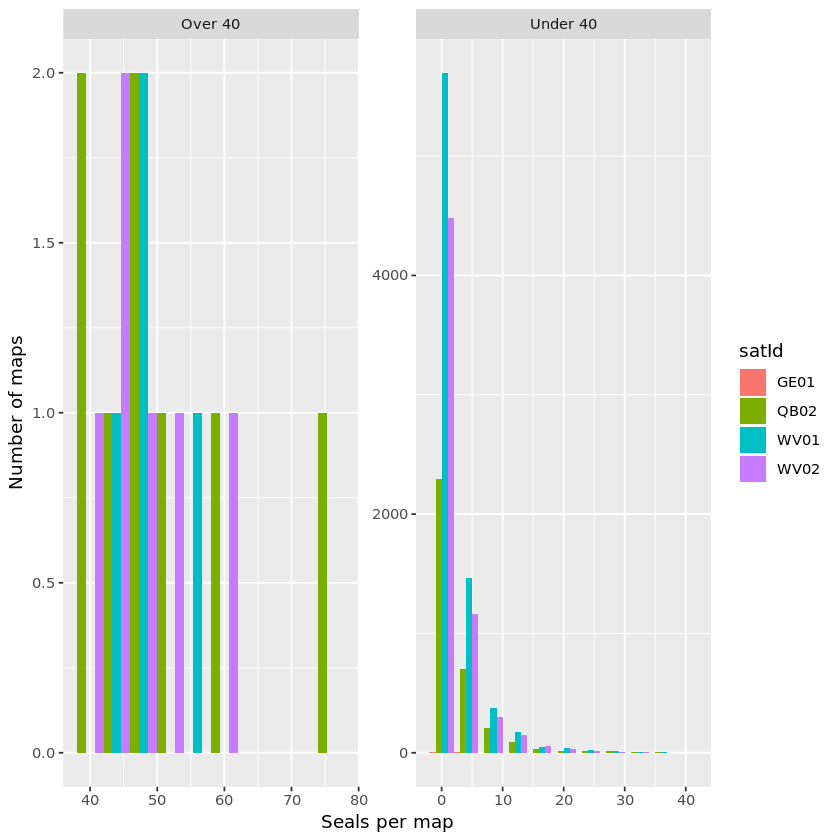

In [43]:
pdf<-merge(counts,unique(overlays[,c("overlayId","acquisition_date")]),by="overlayId",all.x=TRUE)
pdf$originHour<-format(pdf$acquisition_date,"%H")
pdf$originTZ<-format(pdf$acquisition_date,"%Z")
pdf$RShour<-ifelse(pdf$originTZ=="PDT",as.numeric(pdf$originHour)+20,ifelse(pdf$originTZ=="PST",as.numeric(pdf$originHour)+21,as.numeric(pdf$originHour)))
pdf$RShour<-pdf$RShour %% 24
pdf$RShour<-ifelse(pdf$RShour<10,paste0("0",pdf$RShour),as.character(pdf$RShour))
pdf<-merge(pdf,maps[,c("regionMapId","mapcoords.x1","mapcoords.x2")],by="regionMapId",all.x=TRUE)
pdf$abBin<-ifelse(pdf$estNumSeals<=40,"Under 40","Over 40")
ggplot(pdf,aes(x=estNumSeals)) + geom_histogram(aes(fill=satId),position="dodge",binwidth=4) + facet_wrap(~abBin,scales="free") + labs(x="Seals per map",y="Number of maps")
aggregate(regionMapId~satId,pdf,NROW)

The results above suggest no relationship between sensor type and high-count map estimates. The number of possible outlier counts in maps (i.e., maps with counts > 40) is only 18 maps (out of 17,449), and they are distributed among all 3 sensors (QB02, WV01 and WV02 - very few maps were surveyed with GE01).   

## Removing the hour effect
The below graphs of counts by hour attempt to show that seals have a daily pattern of dives that results in more seals in the water (thus not detectable in the satellite images) at certain times of the day, and more seals on ice at other times. We accounted for this effect when we constructed correction models vs ground counts. However, these models were fitted with a different set of data. In fact, the dataset we used to construct these correction models did not include all hours of the day. The dataset for the full continent includes samples from all hours.  
  
Our goal here is to fit a model for the hour effect, so that we can then remove this effect from the data, and then use our ground-count-correction models setting the hour effect to 0 (because we already adjusted for it). How do we do that?
  
We want the count values as if they all came from images taken within the same hour. To do this, we first fit a model with the hour effect. We then predict to the same model but with 0 hour effect. That is, we estimate what the count would be if it happened an hour where the hour effect is 0. Since we have unexplained variance (even after accounting for the hour effect), we must add this unexplained variance back to the estimates at 0 hour. Thus, we add the residuals from the original model fit to the predicted values at hour 0. To also modify the lower and upper confidence limits for each count after removing hour effects, we calculate the original ratios (lower/mean and upper/mean) and use them to estimate the new limits after correcting for hour effects.

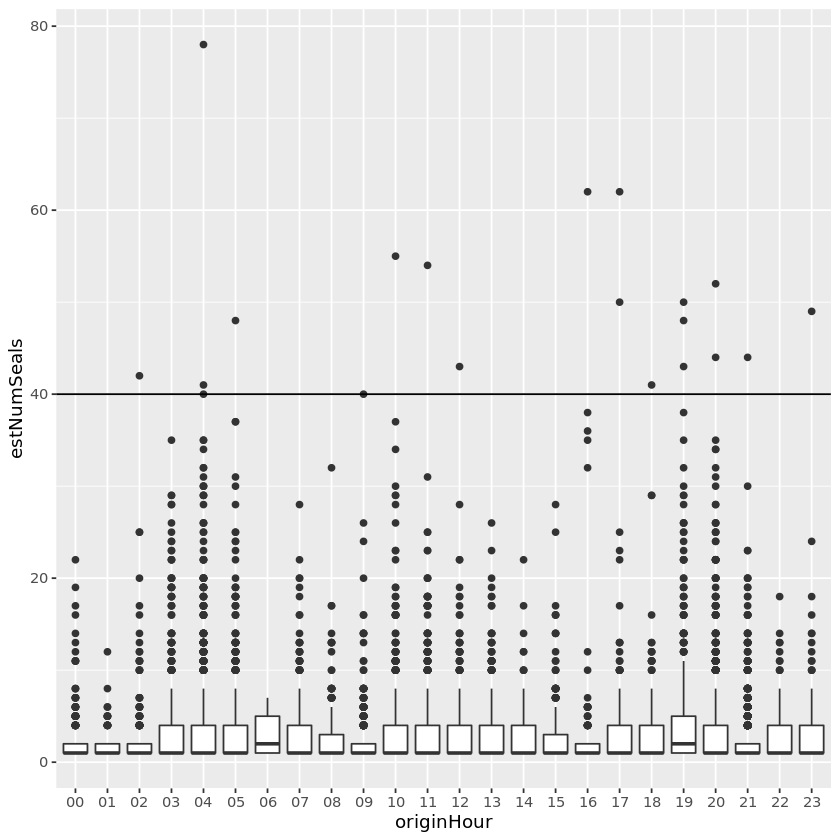

In [346]:
ggplot(pdf,aes(x=originHour,y=estNumSeals))+geom_boxplot() + geom_hline(yintercept=40)

Now we add some important and needed covariates...

In [167]:
nrow(counts);nrow(pdf)
counts<-pdf[,c('regionMapId','region','year','satId','numTaggers','estNumSeals','uclNumSeals','lclNumSeals','corrMethod','crThreshold','acquisition_date','originHour','originTZ','mapcoords.x1','mapcoords.x2')]

[1] 17599

[1] 17449

In [51]:
# THIS TAKES TIME! Splitting so we run only once
ntdf<-ldply(.data=unique(countByQ$regionMapId),.fun=function(m,views,tags){
            mv<-subset(views,regionMapId==m)
            numViews<-nrow(mv)
            mt<-subset(tags,regionMapViewId %in% unique(mv$regionMapViewId))
            numTaggers<-NROW(unique(mt$taggerId))
            totalTags<-nrow(mt)
            tdf<-data.frame(regionMapId=m,numViews=numViews,totalTags=totalTags,avgTags=(totalTags/numTaggers))
        },views=views,tags=tags)
head(ntdf)

,regionMapId,numViews,totalTags,avgTags
,<fct>,<int>,<int>,<dbl>
1,AMU101663,8,1,1
2,AMU102072,6,2,1
3,AMU102099,6,2,2
4,AMU103615,8,1,1
5,AMU103695,9,1,1
6,AMU103791,15,8,8


In [168]:
# Merge with counts
counts<-merge(counts,ntdf,by="regionMapId",all.x=T)
counts$scaledTotalTags<-scale(counts$totalTags); counts$scaledTotalTags<-as.numeric(counts$scaledTotalTags)
counts$scaledAvgTags<-scale(counts$avgTags); counts$scaledAvgTags<-as.numeric(counts$scaledAvgTags)
head(counts)

,regionMapId,region,year,satId,numTaggers,estNumSeals,uclNumSeals,lclNumSeals,corrMethod,crThreshold,acquisition_date,originHour,originTZ,mapcoords.x1,mapcoords.x2,numViews,totalTags,avgTags,scaledTotalTags,scaledAvgTags
,<chr>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dttm>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,AMU101663,AMU,2010,WV01,1,1,4,1,taggerQval,0.5,2010-11-20 21:50:18,21,PST,-85.48336,-73.34752,8,1,1,-0.33940735,-0.5364323
2,AMU102072,AMU,2010,WV01,2,1,4,1,taggerQval,0.5,2010-11-20 21:50:18,21,PST,-85.44474,-73.41747,6,2,1,-0.29654759,-0.5364323
3,AMU102099,AMU,2010,WV01,1,1,4,1,taggerQval,0.5,2010-11-20 21:50:18,21,PST,-85.79235,-73.17324,6,2,2,-0.29654759,-0.3348438
4,AMU103615,AMU,2010,WV01,1,1,4,1,taggerQval,0.5,2010-11-20 21:50:18,21,PST,-85.79235,-73.17696,8,1,1,-0.33940735,-0.5364323
5,AMU103695,AMU,2010,WV01,1,1,4,1,taggerQval,0.5,2010-11-20 21:50:18,21,PST,-85.79235,-73.16951,9,1,1,-0.33940735,-0.5364323
6,AMU103791,AMU,2010,WV01,1,6,14,1,taggerQval,0.5,2010-11-20 21:50:18,21,PST,-85.81166,-73.17324,15,8,8,-0.03938903,0.8746872


Now we load the expert's counts in a few locations in the Weddell Sea. These were from maps that were not exposed to the citizen scientists.

In [169]:
load(file=paste0(pathToLocalGit,"data/MLR_WeddellSea_counts.RData"))
weddellMaps<-weddellMaps[,which(names(weddellMaps) %in% names(counts))]
occ<-nrow(counts)
counts<-counts[,names(weddellMaps)]
counts<-rbind(counts,weddellMaps)
nrow(counts)==nrow(weddellMaps)+occ

[1] TRUE

We fit a base model against which to compare hour model performance for model selection, then explore for the most appropriate modulus for the hour effect.NOTE: we tried including numViews and year effects, but these were non-important, so we removed them.  

In [171]:
counts$avgTags<-counts$totalTags/counts$numTaggers
counts$logAvgTags<-log(counts$avgTags)mdlb<-lm(estNumSeals~logAvgTags,data=counts) 	
summary(mdlb)


Call:
lm(formula = estNumSeals ~ logAvgTags, data = counts)

Residuals:
   Min     1Q Median     3Q    Max 
-2.943 -1.317 -0.799  1.308 60.978 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.30849    0.02473  -12.47   <2e-16 ***
logAvgTags   3.78828    0.02049  184.86   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.323 on 17493 degrees of freedom
Multiple R-squared:  0.6614,	Adjusted R-squared:  0.6614 
F-statistic: 3.417e+04 on 1 and 17493 DF,  p-value: < 2.2e-16


Now we explore the sinusoidal model to find the best basis and modulus.

In [172]:
hourdf<-data.frame(model="base",aicv=AIC(mdlb), bicv=BIC(mdlb), lmdlv=logLik(mdlb), dfv=nrow(counts)-mdlb$df.residual)
for(hh in c(3:12,24)){
    for(bb in 0:11){
        df<-counts
        df$numHour<-((as.integer(counts$originHour)-bb) %% hh)/hh  #We test various moduli
        sindf<-unique(df[,c("originHour","numHour")])
        sindf$sinH<-sin(2*pi*sindf$numHour)
        df<-merge(df,sindf[,c("originHour","sinH")],by="originHour",all.x=T)

        mdlh<-lm(estNumSeals~logAvgTags+sinH+I(sinH^2),data=df)
        hdf<-data.frame(model=paste0("mod",hh,"_basis",bb),aicv=AIC(mdlh), bicv=BIC(mdlh), lmdlv=logLik(mdlh), dfv=nrow(counts)-mdlh$df.residual)
        hourdf<-rbind(hourdf,hdf)
    }
}
hourdf<-hourdf[order(hourdf$aicv),]
head(hourdf,30)

,model,aicv,bicv,lmdlv,dfv
,<fct>,<dbl>,<dbl>,<dbl>,<int>
63,mod8_basis1,79116.95,79155.79,-39553.47,4
67,mod8_basis5,79116.95,79155.79,-39553.47,4
71,mod8_basis9,79116.95,79155.79,-39553.47,4
126,mod24_basis4,79117.91,79156.76,-39553.95,4
127,mod24_basis5,79121.49,79160.34,-39555.75,4
125,mod24_basis3,79121.83,79160.68,-39555.92,4
52,mod7_basis2,79123.80,79162.65,-39556.90,4
59,mod7_basis9,79123.80,79162.65,-39556.90,4
62,mod8_basis0,79124.32,79163.17,-39557.16,4


Modulus 8 is the best fit! This means a full cycle every 8 hrs. If we did not account for other covariates, does this resuld hold?

In [173]:
hourdf<-data.frame()
for(hh in c(3:12,24)){
    for(bb in 0:11){
        df<-counts
        df$numHour<-((as.integer(counts$originHour)-bb) %% hh)/hh  #We test various moduli
        sindf<-unique(df[,c("originHour","numHour")])
        sindf$sinH<-sin(2*pi*sindf$numHour)
        df<-merge(df,sindf[,c("originHour","sinH")],by="originHour",all.x=T)

        mdlh<-lm(estNumSeals~sinH+I(sinH^2),data=df)
        hdf<-data.frame(model=paste0("mod",hh,"_basis",bb),aicv=AIC(mdlh), bicv=BIC(mdlh), lmdlv=logLik(mdlh), dfv=nrow(counts)-mdlh$df.residual)
        hourdf<-rbind(hourdf,hdf)
    }
}
hourdf<-hourdf[order(hourdf$aicv),]
head(hourdf,30)

,model,aicv,bicv,lmdlv,dfv
,<fct>,<dbl>,<dbl>,<dbl>,<int>
62,mod8_basis1,97962.61,97993.69,-48977.31,3
66,mod8_basis5,97962.61,97993.69,-48977.31,3
70,mod8_basis9,97962.61,97993.69,-48977.31,3
55,mod7_basis6,97974.12,98005.20,-48983.06,3
52,mod7_basis3,97981.77,98012.85,-48986.89,3
59,mod7_basis10,97981.77,98012.85,-48986.89,3
51,mod7_basis2,98007.51,98038.59,-48999.75,3
58,mod7_basis9,98007.51,98038.59,-48999.75,3
49,mod7_basis0,98018.48,98049.56,-49005.24,3


Yes, so modulus 8 (i.e., 3 full cycles in a day) is the best fit.

We use the full model with the best hour shift and modulus:

In [174]:
df<-counts
df$numHour<-((as.integer(df$originHour) - 1) %% 8)/8  
sindf<-unique(df[,c("originHour","numHour")])
sindf$sinH<-sin(2*pi*sindf$numHour)
df<-merge(df,sindf[,c("originHour","sinH")],by="originHour",all.x=T)

mdlh<-lm(estNumSeals~logAvgTags+sinH+I(sinH^2),data=df)
summary(mdlh)


Call:
lm(formula = estNumSeals ~ logAvgTags + sinH + I(sinH^2), data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-3.106 -1.383 -0.820  1.237 60.948 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.39441    0.03266 -12.077  < 2e-16 ***
logAvgTags   3.77915    0.02053 184.055  < 2e-16 ***
sinH         0.12898    0.02798   4.610 4.05e-06 ***
I(sinH^2)    0.13265    0.04784   2.773  0.00556 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.321 on 17491 degrees of freedom
Multiple R-squared:  0.6621,	Adjusted R-squared:  0.662 
F-statistic: 1.142e+04 on 3 and 17491 DF,  p-value: < 2.2e-16


Now we create a new dataset to predict to, but fixing numHour to the peak of the sinusoidal, i.e., sinH = 1. (Aside: since the function is in radians and the basis is 1 AM with modulus 8, then the peak is pi/2 past 1 AM, or 1 + 1/4 of 8 hrs = 1 + 2 = 3 AM.) We then predict to this dataset and add the predicted values to the count data.frame. 

In [175]:
newdf<-counts
newdf$sinH<-1   #this is the peak of the sinusoidal, at 12 noon
newdf$predicted<-round(predict(mdlh,newdata=newdf))
newdf$predicted<-ifelse(newdf$predicted<0,0,newdf$predicted)
head(newdf)

,regionMapId,lclNumSeals,estNumSeals,uclNumSeals,mapcoords.x1,mapcoords.x2,acquisition_date,region,satId,numViews,⋯,corrMethod,crThreshold,originTZ,year,totalTags,scaledTotalTags,avgTags,logAvgTags,sinH,predicted
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>,<chr>,<dbl>,⋯,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AMU101663,1,1,4,-85.48336,-73.34752,2010-11-20 21:50:18,AMU,WV01,8,⋯,taggerQval,0.5,PST,2010,1,-0.33940735,1,0.0000000,1,0
2,AMU102072,1,1,4,-85.44474,-73.41747,2010-11-20 21:50:18,AMU,WV01,6,⋯,taggerQval,0.5,PST,2010,2,-0.29654759,1,0.0000000,1,0
3,AMU102099,1,1,4,-85.79235,-73.17324,2010-11-20 21:50:18,AMU,WV01,6,⋯,taggerQval,0.5,PST,2010,2,-0.29654759,2,0.6931472,1,2
4,AMU103615,1,1,4,-85.79235,-73.17696,2010-11-20 21:50:18,AMU,WV01,8,⋯,taggerQval,0.5,PST,2010,1,-0.33940735,1,0.0000000,1,0
5,AMU103695,1,1,4,-85.79235,-73.16951,2010-11-20 21:50:18,AMU,WV01,9,⋯,taggerQval,0.5,PST,2010,1,-0.33940735,1,0.0000000,1,0
6,AMU103791,1,6,14,-85.81166,-73.17324,2010-11-20 21:50:18,AMU,WV01,15,⋯,taggerQval,0.5,PST,2010,8,-0.03938903,8,2.0794415,1,8


And now we use the difference between the predicted and the original estimate to inflate or deflate the ucl and lcl values

In [177]:
newdf$hourCorr<-newdf$predicted - newdf$estNumSeals
newdf$corrLclNumSeals<-newdf$lclNumSeals+newdf$hourCorr
newdf$corrUclNumSeals<-newdf$uclNumSeals+newdf$hourCorr
estByRegionCorr<-as.data.frame(newdf %>% group_by(region) %>% dplyr::summarize(
    corrLclNumSeals=sum(corrLclNumSeals),corrNumSeals=sum(predicted),corrUclNumSeals=sum(corrUclNumSeals),
    lclNumSeals=sum(lclNumSeals),estNumSeals=sum(estNumSeals),uclNumSeals=sum(uclNumSeals))
)
estByRegionCorr<-rbind(estByRegionCorr,
    data.frame(region="Total",
        corrLclNumSeals=sum(estByRegionCorr$corrLclNumSeals),corrNumSeals=sum(estByRegionCorr$corrNumSeals),corrUclNumSeals=sum(estByRegionCorr$corrUclNumSeals),
        lclNumSeals=sum(estByRegionCorr$lclNumSeals),estNumSeals=sum(estByRegionCorr$estNumSeals),uclNumSeals=sum(estByRegionCorr$uclNumSeals)))
print(estByRegionCorr)

  region corrLclNumSeals corrNumSeals corrUclNumSeals lclNumSeals estNumSeals
1    AMU            1289         2465            6499        1013        2189
2    EA1            2720         6312           16471        2375        5967
3    EA2            2864         5753           14624        2174        5063
4    QMA            3682         7991           20186        2833        7142
5    RSS            8207        22210           59559        8330       22333
6    WAP            3552         8554           22077        3230        8232
7  Total           22314        53285          139416       19955       50926
  uclNumSeals
1        6223
2       16126
3       13934
4       19337
5       59682
6       21755
7      137057


In the above table, the first 3 columns are the hour-hour corrected values. Compare to the original (the last 3 columns)

In [178]:
head(newdf)


,regionMapId,lclNumSeals,estNumSeals,uclNumSeals,mapcoords.x1,mapcoords.x2,acquisition_date,region,satId,numViews,⋯,year,totalTags,scaledTotalTags,avgTags,logAvgTags,sinH,predicted,hourCorr,corrLclNumSeals,corrUclNumSeals
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>,<chr>,<dbl>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AMU101663,1,1,4,-85.48336,-73.34752,2010-11-20 21:50:18,AMU,WV01,8,⋯,2010,1,-0.33940735,1,0.0000000,1,0,-1,0,3
2,AMU102072,1,1,4,-85.44474,-73.41747,2010-11-20 21:50:18,AMU,WV01,6,⋯,2010,2,-0.29654759,1,0.0000000,1,0,-1,0,3
3,AMU102099,1,1,4,-85.79235,-73.17324,2010-11-20 21:50:18,AMU,WV01,6,⋯,2010,2,-0.29654759,2,0.6931472,1,2,1,2,5
4,AMU103615,1,1,4,-85.79235,-73.17696,2010-11-20 21:50:18,AMU,WV01,8,⋯,2010,1,-0.33940735,1,0.0000000,1,0,-1,0,3
5,AMU103695,1,1,4,-85.79235,-73.16951,2010-11-20 21:50:18,AMU,WV01,9,⋯,2010,1,-0.33940735,1,0.0000000,1,0,-1,0,3
6,AMU103791,1,6,14,-85.81166,-73.17324,2010-11-20 21:50:18,AMU,WV01,15,⋯,2010,8,-0.03938903,8,2.0794415,1,8,2,3,16


Perfect. We now save these results and move on to inflating for the discrepancy from ground counts.

In [179]:
corrcounts<-newdf
save(counts, corrcounts, mdlb, mdlh, ntdf, countByQ, countByQG, countBySS, gspm, gspmG, gspmQ, gspmQG, 
    file=paste0(pathToLocalGit,"data/countsCorrectedByHour.Rdata"))